In [2]:
import numpy as np
import pandas as pd 
import os
import json
import torch
from torchvision import transforms
from torch.nn import functional as F
import random
import argparse
from models import vae
from models import vae_reward
from models import vae_vgg 
from models import vaernn_no_gmm 
from models import vr
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter 
from collections import OrderedDict

import pickle

from utils.misc import LSIZE, RED_SIZE, ASIZE, RSIZE

from data.loaders import RolloutObservationDataset
from data.loaders import RolloutSequenceDataset
from data.loaders import RolloutRewardDataset

os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

In [3]:
device = torch.device('cpu')

In [4]:
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [5]:
### Set directory paths 
DATA_DIR = "/home/gengar888/world-models/rollouts/"
vae_dir = "/home/megumisano/world-models/exp_dir/vae"  #"/home/gengar888/world-models/exp_dir/vae"
vae_reward_dir = "/home/megumisano/world-models/exp_dir/vae_reward" 
vae_reward_eval_dir = "/home/megumisano/world-models/exp_dir/vae_reward_eval"
vae_vgg_dir = "/home/gengar888/world-models/exp_dir/vgg"
vae_rnn_dir = "/home/gengar888/enhanced_world_models/exp_dir/vaernn_no_gmm"
vae_rnn_frozen_dir = "/home/gengar888/enhanced_world_models/exp_dir/vaernn"

In [6]:
### Load observation dataset (without reward)

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((RED_SIZE, RED_SIZE)),
    transforms.ToTensor(),
])

dataset_test = RolloutObservationDataset(DATA_DIR,
                                         transform_test, train=False)

test_loader_no_reward = torch.utils.data.DataLoader(
    dataset_test, batch_size=32, shuffle=True, num_workers=0)

dataset_test.load_next_buffer()

Loading file buffer ...: 100%|██████████| 200/200 
Loading file buffer ...: 100%|██████████| 200/200 


In [39]:
### Load sequence datset (with reward)

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((RED_SIZE, RED_SIZE)),
    transforms.ToTensor(),
])

test_loader_with_reward = torch.utils.data.DataLoader(
    RolloutRewardDataset(DATA_DIR, transform_test, train=False, buffer_size=10),
    batch_size=32, num_workers=0)

test_loader_with_reward.dataset.load_next_buffer()


  0%|          | 0/10 
Loading file buffer ...:   0%|          | 0/10 
Loading file buffer ...:  30%|███       | 3/10 
Loading file buffer ...:  60%|██████    | 6/10 
Loading file buffer ...:  90%|█████████ | 9/10 
Loading file buffer ...: 100%|██████████| 10/10 

### Loading retrained VAE and ResNet50 

In [7]:
# Load VAE 
vae_ = vae.VAE(3, LSIZE)
reload_file = os.path.join(vae_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
# ### print loss curves 
# reload_file = os.path.join(vae_dir, 'checkpoint.tar')
# state = torch.load(reload_file, map_location=lambda storage, loc: storage)
# precisions = state['precision'] # which oen is it 

In [9]:
# Load VAE with reward 
vae_reward_ = vae_reward.VAE(3, LSIZE)
reload_file = os.path.join(vae_reward_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_reward_.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [42]:
# Load VAE with reward 
vae_vgg= vae_vgg.VAE_VGG(3, LSIZE)
reload_file = os.path.join(vae_vgg_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_vgg.load_state_dict(state['state_dict'], strict=False)

KeyboardInterrupt: 

In [10]:
# Load VAE with reward  eval 
vae_reward_eval = vae_reward.VAE(3, LSIZE)
reload_file = os.path.join(vae_reward_eval_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_reward_eval.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
# Load VAE RNN 
vae_rnn = vaernn_no_gmm.VAERNN_NOGMM(LSIZE, ASIZE, RSIZE, 5)
reload_file = os.path.join(vae_rnn_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_rnn.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
# Load VAE RNN 
vae_rnn_frozen = vr.VAERNN(LSIZE, ASIZE, RSIZE, 5)
reload_file = os.path.join(vae_rnn_frozen_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_rnn_frozen.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [12]:
# Convert state dict so that we can load just VAE weights 
new = OrderedDict()
for key, value in state['state_dict'].items():
    if key.startswith('vae'):
        prev = key
        new[prev[4:]] = value
state['state_dict'].update(new)

In [13]:
# Load just VAE weights 
vae_from_vaernn = vae.VAE(3, LSIZE)
vae_from_vaernn.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=['obs_linear.weight', 'obs_linear.bias', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'vae.encoder.conv1.weight', 'vae.encoder.conv1.bias', 'vae.encoder.conv2.weight', 'vae.encoder.conv2.bias', 'vae.encoder.conv3.weight', 'vae.encoder.conv3.bias', 'vae.encoder.conv4.weight', 'vae.encoder.conv4.bias', 'vae.encoder.fc_mu.weight', 'vae.encoder.fc_mu.bias', 'vae.encoder.fc_logsigma.weight', 'vae.encoder.fc_logsigma.bias', 'vae.decoder.fc1.weight', 'vae.decoder.fc1.bias', 'vae.decoder.deconv1.weight', 'vae.decoder.deconv1.bias', 'vae.decoder.deconv2.weight', 'vae.decoder.deconv2.bias', 'vae.decoder.deconv3.weight', 'vae.decoder.deconv3.bias', 'vae.decoder.deconv4.weight', 'vae.decoder.deconv4.bias'])

In [15]:
# Convert state dict so that we can load just VAE weights 
new = OrderedDict()
for key, value in state['state_dict'].items():
    if key.startswith('vae'):
        prev = key
        new[prev[4:]] = value
state['state_dict'].update(new)

In [16]:
# Load just VAE weights 
vae_from_vaernn_frozen = vae.VAE(3, LSIZE)
vae_from_vaernn_frozen.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=['gmm_linear.weight', 'gmm_linear.bias', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'vae.encoder.conv1.weight', 'vae.encoder.conv1.bias', 'vae.encoder.conv2.weight', 'vae.encoder.conv2.bias', 'vae.encoder.conv3.weight', 'vae.encoder.conv3.bias', 'vae.encoder.conv4.weight', 'vae.encoder.conv4.bias', 'vae.encoder.fc_mu.weight', 'vae.encoder.fc_mu.bias', 'vae.encoder.fc_logsigma.weight', 'vae.encoder.fc_logsigma.bias', 'vae.decoder.fc1.weight', 'vae.decoder.fc1.bias', 'vae.decoder.deconv1.weight', 'vae.decoder.deconv1.bias', 'vae.decoder.deconv2.weight', 'vae.decoder.deconv2.bias', 'vae.decoder.deconv3.weight', 'vae.decoder.deconv3.bias', 'vae.decoder.deconv4.weight', 'vae.decoder.deconv4.bias'])

### Calculate reconstruction loss on test set 

In [215]:
def loss_function(recon_x, x):
    """ VAE loss function """
    BCE = F.mse_loss(recon_x, x, size_average=False)
    #KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())
    return BCE #+ KLD

def test(vae, which):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader_no_reward:
            if which == 'vae':
                recon_batch, mu, logvar = vae(data)
            elif which == 'reward':
                recon_batch, mu, logvar, predicted_reward = vae(data)
            else:
                recon_batch, z = vae(data)
            test_loss += loss_function(recon_batch, data).item()
    test_loss /= len(test_loader_no_reward.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [12]:
vae_reconstruct_loss = test(vae, 'vae')

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Test set loss: 15.4981


In [13]:
vae_reward_reconstruct_loss = test(vae_reward_, 'reward')

====> Test set loss: 13.5084


In [31]:
vgg_reconstruct_loss = test(vae_vgg, 'vgg') # 23 something... 

AttributeError: module 'models.vae_vgg' has no attribute 'eval'

In [16]:
vae_reward_eval_reconstruct_loss = test(vae_reward_eval, 'reward')

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Test set loss: 13.9474


In [134]:
vae_from_vaernn_reconstruct_loss = test(vae_from_vaernn, 'vae')

====> Test set loss: 22.0068


In [210]:
import warnings 
warnings.filterwarnings('ignore')
vae_from_vaernn_frozen_reconstruct_loss = test(vae_from_vaernn_frozen, 'vae')

====> Test set loss: 21.6550


### Using KL Divergence:

In [211]:
def loss_function(recon_x, logsigma, mu, x):
    """ VAE loss function """
    BCE = F.mse_loss(recon_x, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())
    return BCE + KLD

def test(vae, which):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader_no_reward:
            if which == 'vae':
                recon_batch, mu, logvar = vae(data)
            elif which == 'reward':
                recon_batch, mu, logvar, predicted_reward = vae(data)
            test_loss += loss_function(recon_batch, logvar, mu, data).item()
    test_loss /= len(test_loader_no_reward.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [54]:
vae_reconstruct_loss_with_kl = test(vae, 'vae')

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Test set loss: 26.6500


In [57]:
vae_reward_reconstruct_loss_with_kl = test(vae_reward_, 'reward')

====> Test set loss: 23.8185


In [58]:
vae_reward_eval_reconstruct_loss_with_kl = test(vae_reward_eval, 'reward')

====> Test set loss: 24.5004


In [131]:
vae_from_vaernn_reconstruct_loss_with_kl = test(vae_from_vaernn, 'vae')  

====> Test set loss: 33.3176


In [212]:
import warnings 
warnings.filterwarnings('ignore')
vae_from_vaernn_frozen_reconstruct_loss_with_kl = test(vae_from_vaernn_frozen, 'vae')

====> Test set loss: 31.2964


### Evaluating predictor network 

In [26]:
def loss_function_eval(recon_x, x, mu, logsigma, predicted_reward, actual_reward):
    """ VAE loss function """
    BCE = F.mse_loss(recon_x, x, size_average=False)

    KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())

    actuals = []
    for i, act in enumerate(actual_reward): 
        if act.item() > -50 and act.item() < 0:
            actual = 0 # torch.tensor(0)#torch.tensor([1, 0, 0])
        elif act.item() <= -50:
            actual = 1 # torch.tensor(1)#torch.tensor([0, 1, 0])
        else:
            actual = 2 #torch.tensor(2)#torch.tensor([0, 0, 1])
        actuals.append(actual)
    actuals = torch.tensor(actuals)
    predicted_reward = predicted_reward.to(device) 

    predicted_reward_indices = np.argmax(predicted_reward, axis=1)

    RPL = F.cross_entropy(predicted_reward, actuals)
    
    return BCE + KLD + RPL, actuals, predicted_reward_indices

def test_eval(model):
    """ One test epoch """
    model.eval()
    test_loss = 0
    
    total_prfs_dict = {'macro': (0, 0, 0), 'micro': (0, 0, 0), 'weighted':(0, 0, 0), 'none':(0, 0, 0)}
    y_true = np.array([])
    y_pred = np.array([])
    
    with torch.no_grad():
        for data in test_loader_with_reward:
            obs, reward = data
            actual_reward=reward
            recon_batch, mu, logvar, predicted_reward = model(obs)
            loss, actuals, predicted_reward_indices = loss_function_eval(recon_batch, obs, mu, logvar, predicted_reward, actual_reward)
            test_loss += loss.item() 
            y_true = np.append(y_true, actuals) 
            y_pred = np.append(y_pred, predicted_reward_indices) 
            
    test_loss /= len(test_loader_with_reward.dataset)
    
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    
    y_pred = [p % 2 for p in y_pred]
    
    y_pred_counts = Counter(y_pred)
    y_true_counts = Counter(y_true)

    for avr in ['macro', 'micro', 'weighted']:
        total_prfs_dict[avr] = precision_recall_fscore_support(y_true, y_pred, average=avr)
    
    total_prfs_dict['none'] = precision_recall_fscore_support(y_true, y_pred, average=None)
    
#     total_prfs_dict['macro'] /= len(test_loader_with_reward.dataset)
#     total_prfs_dict['micro'] /=  len(test_loader_with_reward.dataset)
#     total_prfs_dict['weighted'] /=  len(test_loader_with_reward.dataset)

    print('====> Test set loss: {:.4f}'.format(test_loss))
    print('====> Average macro: {} Average micro: {}  Average weighted: {}'.format(total_prfs_dict['macro'], total_prfs_dict['micro'], total_prfs_dict['weighted']))
    
    print(total_prfs_dict['none'])
    
    print("prediction counts: {}".format(y_pred_counts))
    print("actual counts: {}".format(y_true_counts))
    
    
    return test_loss

In [27]:
test_eval(vae_reward)

KeyboardInterrupt: 

### Probing imbalanced classification problem 

In [8]:
train_loss_list, test_loss_list, train_total_prfs_dict_list, test_total_prfs_dict_list, train_y_pred_counts_list, test_y_pred_counts_list, train_y_true_counts_list, test_y_true_counts_list = pickle.load(open('vae_reward_eval_scores.p', 'rb'))

In [9]:
train_loss_list2, test_loss_list2, train_total_prfs_dict_list2, test_total_prfs_dict_list2, train_y_pred_counts_list2, test_y_pred_counts_list2, train_y_true_counts_list2, test_y_true_counts_list2 = pickle.load(open('vae_reward_eval_scores_2.p', 'rb'))

In [12]:
vae_reward_eval_scores_df = pd.DataFrame()

In [62]:
vae_reward_eval_scores_df['train_loss'] = train_loss_list + train_loss_list2 

vae_reward_eval_scores_df['train_macro_precision'] = [t['macro'][0] for t in train_total_prfs_dict_list] + [t['macro'][0] for t in train_total_prfs_dict_list2]
vae_reward_eval_scores_df['train_macro_recall'] = [t['macro'][1] for t in train_total_prfs_dict_list] + [t['macro'][1] for t in train_total_prfs_dict_list2]
vae_reward_eval_scores_df['train_macro_f1'] = [t['macro'][2] for t in train_total_prfs_dict_list] + [t['macro'][2] for t in train_total_prfs_dict_list2]
vae_reward_eval_scores_df['train_macro_support'] = [t['macro'][3] for t in train_total_prfs_dict_list] + [t['macro'][3] for t in train_total_prfs_dict_list2]

vae_reward_eval_scores_df['train_micro_precision'] = [t['micro'][0] for t in train_total_prfs_dict_list] + [t['micro'][0] for t in train_total_prfs_dict_list2]
vae_reward_eval_scores_df['train_micro_recall'] = [t['micro'][1] for t in train_total_prfs_dict_list] + [t['micro'][1] for t in train_total_prfs_dict_list2]
vae_reward_eval_scores_df['train_micro_f1'] = [t['micro'][2]  for t in train_total_prfs_dict_list] + [t['micro'][2]  for t in train_total_prfs_dict_list2]
vae_reward_eval_scores_df['train_micro_support'] = [t['micro'][3] for t in train_total_prfs_dict_list] + [t['micro'][3] for t in train_total_prfs_dict_list2]

vae_reward_eval_scores_df['train_weighted_precision'] = [t['weighted'][0] for t in train_total_prfs_dict_list] + [t['weighted'][0] for t in train_total_prfs_dict_list2]
vae_reward_eval_scores_df['train_weighted_recall'] = [t['weighted'][1] for t in train_total_prfs_dict_list] + [t['weighted'][1] for t in train_total_prfs_dict_list2]
vae_reward_eval_scores_df['train_weighted_f1'] = [t['weighted'][2] for t in train_total_prfs_dict_list] + [t['weighted'][2] for t in train_total_prfs_dict_list2]
vae_reward_eval_scores_df['train_weighted_support'] = [t['weighted'][3] for t in train_total_prfs_dict_list] +  [t['weighted'][3] for t in train_total_prfs_dict_list2]


        
vae_reward_eval_scores_df['train_none_precision_1'] = [t['none'][0][0] for t in train_total_prfs_dict_list] + [t['none'][0][0] for t in train_total_prfs_dict_list2]
# vae_reward_eval_scores_df['train_none_precision_2'] = [t['none'][0][1] for t in train_total_prfs_dict_list] + [t['none'][0][1] for t in train_total_prfs_dict_list2]
# vae_reward_eval_scores_df['train_none_precision_3'] = [t['none'][0][2] for t in train_total_prfs_dict_list] + [t['none'][0][2] for t in train_total_prfs_dict_list2]
temp = []
for t in train_total_prfs_dict_list + train_total_prfs_dict_list2:
    if len(t['none'][0]) != 2:
        temp.append(t['none'][0][1])
    else:
        temp.append(0)           
vae_reward_eval_scores_df['train_none_precision_2'] = temp 

temp = []
for t in train_total_prfs_dict_list + train_total_prfs_dict_list2:
    if len(t['none'][0]) != 2:
        temp.append(t['none'][0][2])
    else:
        temp.append(t['none'][0][1])        
vae_reward_eval_scores_df['train_none_precision_3'] = temp 


vae_reward_eval_scores_df['train_none_recall_1'] = [t['none'][1][0] for t in train_total_prfs_dict_list] + [t['none'][1][0] for t in train_total_prfs_dict_list2]
# vae_reward_eval_scores_df['train_none_recall_2'] = [t['none'][1][1] for t in train_total_prfs_dict_list] + [t['none'][1][1] for t in train_total_prfs_dict_list2]
# vae_reward_eval_scores_df['train_none_recall_3'] = [t['none'][1][2] for t in train_total_prfs_dict_list] + [t['none'][1][2] for t in train_total_prfs_dict_list2]
temp = []
for t in train_total_prfs_dict_list + train_total_prfs_dict_list2:
    if len(t['none'][1]) != 2:
        temp.append(t['none'][1][1])
    else:
        temp.append(0)           
vae_reward_eval_scores_df['train_none_recall_2'] = temp 

temp = []
for t in train_total_prfs_dict_list + train_total_prfs_dict_list2:
    if len(t['none'][1]) != 2:
        temp.append(t['none'][1][2])
    else:
        temp.append(t['none'][1][1])        
vae_reward_eval_scores_df['train_none_recall_3'] = temp 


vae_reward_eval_scores_df['train_none_f1_1'] = [t['none'][2][0] for t in train_total_prfs_dict_list] + [t['none'][2][0] for t in train_total_prfs_dict_list2]
# vae_reward_eval_scores_df['train_none_f1_2'] = [t['none'][2][1] for t in train_total_prfs_dict_list] + [t['none'][2][1] for t in train_total_prfs_dict_list2]
# vae_reward_eval_scores_df['train_none_f1_3'] = [t['none'][2][2] for t in train_total_prfs_dict_list] + [t['none'][2][2] for t in train_total_prfs_dict_list2]
temp = []
for t in train_total_prfs_dict_list + train_total_prfs_dict_list2:
    if len(t['none'][2]) != 2:
        temp.append(t['none'][2][1])
    else:
        temp.append(0)           
vae_reward_eval_scores_df['train_none_f1_2'] = temp 

temp = []
for t in train_total_prfs_dict_list + train_total_prfs_dict_list2:
    if len(t['none'][2]) != 2:
        temp.append(t['none'][2][2])
    else:
        temp.append(t['none'][2][1])        
vae_reward_eval_scores_df['train_none_f1_3'] = temp 


vae_reward_eval_scores_df['train_none_support_1'] = [t['none'][3][0] for t in train_total_prfs_dict_list] + [t['none'][3][0] for t in train_total_prfs_dict_list2]
# vae_reward_eval_scores_df['train_none_support_2'] = [t['none'][3][1] for t in train_total_prfs_dict_list] + [t['none'][3][1] for t in train_total_prfs_dict_list2]
# vae_reward_eval_scores_df['train_none_support_3'] = [t['none'][3][2] for t in train_total_prfs_dict_list] + [t['none'][3][2] for t in train_total_prfs_dict_list2]
temp = []
for t in train_total_prfs_dict_list + train_total_prfs_dict_list2:
    if len(t['none'][3]) != 2:
        temp.append(t['none'][3][1])
    else:
        temp.append(0)           
vae_reward_eval_scores_df['train_none_support_2'] = temp 

temp = []
for t in train_total_prfs_dict_list + train_total_prfs_dict_list2:
    if len(t['none'][3]) != 2:
        temp.append(t['none'][3][2])
    else:
        temp.append(t['none'][3][1])        
vae_reward_eval_scores_df['train_none_support_3'] = temp 


vae_reward_eval_scores_df['train_y_pred_counts_1'] = [t[0] for t in train_y_pred_counts_list] + [t[0] for t in train_y_pred_counts_list2]
vae_reward_eval_scores_df['train_y_pred_counts_2'] = [t[1] for t in train_y_pred_counts_list] + [t[1] for t in train_y_pred_counts_list2]
vae_reward_eval_scores_df['train_y_pred_counts_3'] = [t[2] for t in train_y_pred_counts_list] + [t[2] for t in train_y_pred_counts_list2]

vae_reward_eval_scores_df['train_y_true_counts_1'] = [t[0] for t in train_y_true_counts_list] + [t[0] for t in train_y_true_counts_list2]
vae_reward_eval_scores_df['train_y_true_counts_2'] = [t[1] for t in train_y_true_counts_list] + [t[1] for t in train_y_true_counts_list2]
vae_reward_eval_scores_df['train_y_true_counts_3'] = [t[2] for t in train_y_true_counts_list] + [t[2] for t in train_y_true_counts_list2]

vae_reward_eval_scores_df['test_loss'] = test_loss_list + test_loss_list2 

vae_reward_eval_scores_df['test_macro_precision'] = [t['macro'][0] for t in test_total_prfs_dict_list] + [t['macro'][0] for t in test_total_prfs_dict_list2]
vae_reward_eval_scores_df['test_macro_recall'] = [t['macro'][1] for t in test_total_prfs_dict_list] + [t['macro'][1] for t in test_total_prfs_dict_list2]
vae_reward_eval_scores_df['test_macro_f1'] = [t['macro'][2] for t in test_total_prfs_dict_list] + [t['macro'][2] for t in test_total_prfs_dict_list2]
vae_reward_eval_scores_df['test_macro_support'] = [t['macro'][3] for t in test_total_prfs_dict_list] + [t['macro'][3] for t in test_total_prfs_dict_list2]

vae_reward_eval_scores_df['test_micro_precision'] = [t['micro'][0] for t in test_total_prfs_dict_list] + [t['micro'][0] for t in test_total_prfs_dict_list2]
vae_reward_eval_scores_df['test_micro_recall'] = [t['micro'][1] for t in test_total_prfs_dict_list] +  [t['micro'][1] for t in test_total_prfs_dict_list2]
vae_reward_eval_scores_df['test_micro_f1'] = [t['micro'][2] for t in test_total_prfs_dict_list] + [t['micro'][2] for t in test_total_prfs_dict_list2] 
vae_reward_eval_scores_df['test_micro_support'] = [t['micro'][3] for t in test_total_prfs_dict_list] + [t['micro'][3] for t in test_total_prfs_dict_list2]

vae_reward_eval_scores_df['test_weighted_precision'] = [t['weighted'][0] for t in test_total_prfs_dict_list] + [t['weighted'][0] for t in test_total_prfs_dict_list2]
vae_reward_eval_scores_df['test_weighted_recall'] = [t['weighted'][1] for t in test_total_prfs_dict_list] + [t['weighted'][1] for t in test_total_prfs_dict_list2]
vae_reward_eval_scores_df['test_weighted_f1'] = [t['weighted'][2] for t in test_total_prfs_dict_list] + [t['weighted'][2] for t in test_total_prfs_dict_list2]
vae_reward_eval_scores_df['test_weighted_support'] = [t['weighted'][3] for t in test_total_prfs_dict_list] + [t['weighted'][3] for t in test_total_prfs_dict_list2]

vae_reward_eval_scores_df['test_none_precision_1'] = [t['none'][0][0] for t in test_total_prfs_dict_list] + [t['none'][0][0] for t in test_total_prfs_dict_list2]
# vae_reward_eval_scores_df['test_none_precision_2'] = [t['none'][0][1] for t in test_total_prfs_dict_list] + [t['none'][0][1] for t in test_total_prfs_dict_list2]
# vae_reward_eval_scores_df['test_none_precision_3'] = [t['none'][0][2] for t in test_total_prfs_dict_list] + [t['none'][0][2] for t in test_total_prfs_dict_list2]
temp = []
for t in test_total_prfs_dict_list + test_total_prfs_dict_list2:
    if len(t['none'][0]) != 2:
        temp.append(t['none'][0][1])
    else:
        temp.append(0)           
vae_reward_eval_scores_df['test_none_precision_2'] = temp 

temp = []
for t in test_total_prfs_dict_list + test_total_prfs_dict_list2:
    if len(t['none'][0]) != 2:
        temp.append(t['none'][0][2])
    else:
        temp.append(t['none'][0][1])        
vae_reward_eval_scores_df['test_none_precision_3'] = temp 


vae_reward_eval_scores_df['test_none_recall_1'] = [t['none'][1][0] for t in test_total_prfs_dict_list] + [t['none'][1][0] for t in test_total_prfs_dict_list2]
# vae_reward_eval_scores_df['test_none_recall_2'] = [t['none'][1][1] for t in test_total_prfs_dict_list] + [t['none'][1][1] for t in test_total_prfs_dict_list2]
# vae_reward_eval_scores_df['test_none_recall_3'] = [t['none'][1][2] for t in test_total_prfs_dict_list] + [t['none'][1][2] for t in test_total_prfs_dict_list2]
temp = []
for t in test_total_prfs_dict_list + test_total_prfs_dict_list2:
    if len(t['none'][1]) != 2:
        temp.append(t['none'][1][1])
    else:
        temp.append(0)           
vae_reward_eval_scores_df['test_none_recall_2'] = temp 

temp = []
for t in test_total_prfs_dict_list + test_total_prfs_dict_list2:
    if len(t['none'][1]) != 2:
        temp.append(t['none'][1][2])
    else:
        temp.append(t['none'][1][1])        
vae_reward_eval_scores_df['test_none_recall_3'] = temp 


vae_reward_eval_scores_df['test_none_f1_1'] = [t['none'][2][0] for t in test_total_prfs_dict_list] + [t['none'][2][0] for t in test_total_prfs_dict_list2]
# vae_reward_eval_scores_df['test_none_f1_2'] = [t['none'][2][1] for t in test_total_prfs_dict_list] +  [t['none'][2][1] for t in test_total_prfs_dict_list2]
# vae_reward_eval_scores_df['test_none_f1_3'] = [t['none'][2][2] for t in test_total_prfs_dict_list] + [t['none'][2][2] for t in test_total_prfs_dict_list2]
temp = []
for t in test_total_prfs_dict_list + test_total_prfs_dict_list2:
    if len(t['none'][2]) != 2:
        temp.append(t['none'][2][1])
    else:
        temp.append(0)           
vae_reward_eval_scores_df['test_none_f1_2'] = temp 

temp = []
for t in test_total_prfs_dict_list + test_total_prfs_dict_list2:
    if len(t['none'][2]) != 2:
        temp.append(t['none'][2][2])
    else:
        temp.append(t['none'][2][1])        
vae_reward_eval_scores_df['test_none_f1_3'] = temp 


vae_reward_eval_scores_df['test_none_support_1'] = [t['none'][3][0] for t in test_total_prfs_dict_list] + [t['none'][3][0] for t in test_total_prfs_dict_list2]
# vae_reward_eval_scores_df['test_none_support_2'] = [t['none'][3][1] for t in test_total_prfs_dict_list] +  [t['none'][3][1] for t in test_total_prfs_dict_list2]
# vae_reward_eval_scores_df['test_none_support_3'] = [t['none'][3][2] for t in test_total_prfs_dict_list] + [t['none'][3][2] for t in test_total_prfs_dict_list2]
temp = []
for t in test_total_prfs_dict_list + test_total_prfs_dict_list2:
    if len(t['none'][3]) != 2:
        temp.append(t['none'][3][1])
    else:
        temp.append(0)           
vae_reward_eval_scores_df['test_none_support_2'] = temp 

temp = []
for t in test_total_prfs_dict_list + test_total_prfs_dict_list2:
    if len(t['none'][3]) != 2:
        temp.append(t['none'][3][2])
    else:
        temp.append(t['none'][3][1])        
vae_reward_eval_scores_df['test_none_support_3'] = temp 


vae_reward_eval_scores_df['test_y_pred_counts_1'] = [t[0] for t in test_y_pred_counts_list] + [t[0] for t in test_y_pred_counts_list2]
vae_reward_eval_scores_df['test_y_pred_counts_2'] = [t[1] for t in test_y_pred_counts_list] + [t[1] for t in test_y_pred_counts_list2]
vae_reward_eval_scores_df['test_y_pred_counts_3'] = [t[2] for t in test_y_pred_counts_list] + [t[2] for t in test_y_pred_counts_list2]

vae_reward_eval_scores_df['test_y_true_counts_1'] = [t[0] for t in test_y_true_counts_list] + [t[0] for t in test_y_true_counts_list2]
vae_reward_eval_scores_df['test_y_true_counts_2'] = [t[1] for t in test_y_true_counts_list] + [t[1] for t in test_y_true_counts_list2]
vae_reward_eval_scores_df['test_y_true_counts_3'] = [t[2] for t in test_y_true_counts_list] + [t[2] for t in test_y_true_counts_list2]


In [226]:
vae_reward_eval_scores_df = pd.read_csv('vae_reward_eval_scores_df.csv')

In [17]:
train_total_prfs_dict_list # figure out how to do the none one with array of varying sizes 

[{'macro': (0.6364773675510363,
   0.35418816797737773,
   0.37053339285738257,
   None),
  'micro': (0.988615, 0.988615, 0.988615, None),
  'weighted': (0.9878813726454071, 0.988615, 0.9837058626208195, None),
  'none': (array([0.9887, 0.    , 0.9207]),
   array([0.9999, 0.    , 0.0627]),
   array([0.9943, 0.    , 0.1173]),
   array([197590,      0,   2410]))},
 {'macro': (0.9496883173559576, 0.5381590474956391, 0.5676873572040322, None),
  'micro': (0.98885, 0.98885, 0.98885, None),
  'weighted': (0.9879890621978074, 0.98885, 0.9841690875651234, None),
  'none': (array([0.9889, 0.9104]),
   array([0.9999, 0.0764]),
   array([0.9944, 0.141 ]),
   array([197605,   2395]))},
 {'macro': (0.9693163416192077, 0.5391863133329231, 0.5696344894434047, None),
  'micro': (0.988845, 0.988845, 0.988845, None),
  'weighted': (0.9884123604104175, 0.988845, 0.9841493733562289, None),
  'none': (array([0.9889, 0.9497]),
   array([0.9999, 0.0784]),
   array([0.9944, 0.1449]),
   array([197590,   2410]

In [63]:
vae_reward_eval_scores_df.to_csv('vae_reward_eval_scores_df.csv')

In [315]:
# plt.figure(figsize=(20,16))
# plt.subplot(321)

# plt.title('F1 score for first class during training')
# plt.plot(vae_reward_eval_scores_df['train_none_f1_1'])

# plt.subplot(322)
# plt.title('F1 score for second class during training')
# plt.plot(vae_reward_eval_scores_df['train_none_f1_2'])


# plt.subplot(323)
# plt.title('F1 score for third class during training')
# plt.plot(vae_reward_eval_scores_df['train_none_f1_3'])

# plt.subplot(324)
# plt.title('F1 score for first class during testing')
# plt.plot(vae_reward_eval_scores_df['test_none_f1_1'])

# plt.subplot(325)
# plt.title('F1 score for second class during testing') 
# plt.plot(vae_reward_eval_scores_df['test_none_f1_2'])

# plt.subplot(326)
# plt.title('F1 score for third class during testing')
# plt.plot(vae_reward_eval_scores_df['test_none_f1_3'])

# plt.legend()
# plt.show()

In [ ]:
plt.figure(figsize=(20,16))
plt.subplot(231)

plt.title('train reward counts')
plt.plot(vae_reward_eval_scores_df['train_y_pred_counts_1'])
plt.plot(vae_reward_eval_scores_df['train_y_true_counts_1'])


plt.subplot(232)
plt.title('train reward counts')
plt.plot(vae_reward_eval_scores_df['train_y_pred_counts_2'])
plt.plot(vae_reward_eval_scores_df['train_y_true_counts_2'])


plt.subplot(233)
plt.title('train reward counts')
plt.plot(vae_reward_eval_scores_df['train_y_pred_counts_3'])
plt.plot(vae_reward_eval_scores_df['train_y_true_counts_3'])

plt.subplot(234)
plt.title('test reward counts') 
plt.plot(vae_reward_eval_scores_df['test_y_pred_counts_1'])
plt.plot(vae_reward_eval_scores_df['test_y_true_counts_1'])

plt.subplot(235)
plt.title('test reward counts') 
plt.plot(vae_reward_eval_scores_df['test_y_pred_counts_2'])
plt.plot(vae_reward_eval_scores_df['test_y_true_counts_2'])

plt.subplot(236)
plt.title('test reward counts') 
plt.plot(vae_reward_eval_scores_df['test_y_pred_counts_3'])
plt.plot(vae_reward_eval_scores_df['test_y_true_counts_3'])

plt.legend()
plt.show()

In [ ]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn = compare_reconstructed_frame(vae, vae_reward_eval, vae_from_vaernn, test_loader_no_reward, 0)

### Qualitative analysis: reconstructing frames

In [17]:
def compare_reconstructed_frame(vae, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader, index):
    count = 0
    with torch.no_grad():
        for x in test_loader:
            count += 1 
            if count == 1:
                print(x.shape)
                recon_batch, mu, logvar = vae(x)
                original = x[index] 
                reconstruct = recon_batch[index] 
                original= original.numpy().transpose(1, 2, 0)
                reconstruct_vae= reconstruct.numpy().transpose(1,2,0)

                recon_batch, mu, logvar, predicted_reward = vae_reward_eval(x)
                reconstruct = recon_batch[index]
                reconstruct_vae_reward_eval = reconstruct.numpy().transpose(1,2,0)

                recon_batch, mu, logvar = vae_from_vaernn(x)
                reconstruct = recon_batch[index] 
                reconstruct_vae_from_vaernn= reconstruct.numpy().transpose(1,2,0)

                recon_batch, mu, logvar = vae_from_vaernn_frozen(x)
                reconstruct = recon_batch[index] 
                reconstruct_vae_from_vaernn_frozen = reconstruct.numpy().transpose(1,2,0)

                fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(18, 4))
                ax[0].imshow(original)
                ax[0].axis('off')
                plt.xticks([])
                plt.yticks([])
                ax[1].imshow(reconstruct_vae)
                ax[1].axis('off')
                ax[2].imshow(reconstruct_vae_reward_eval)
                ax[2].axis('off')
                ax[3].imshow(reconstruct_vae_from_vaernn)
                ax[3].axis('off')
                ax[4].imshow(reconstruct_vae_from_vaernn_frozen)
                ax[4].axis('off')
                fig.tight_layout()
                plt.show()
                return original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen
            else:
                break

torch.Size([32, 3, 64, 64])


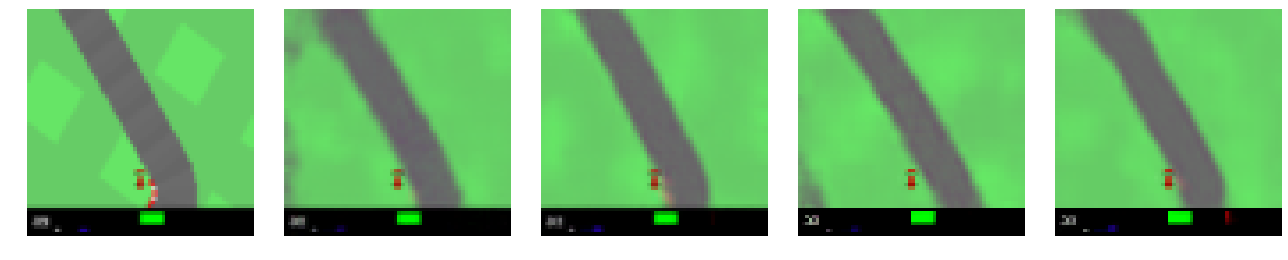

In [333]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


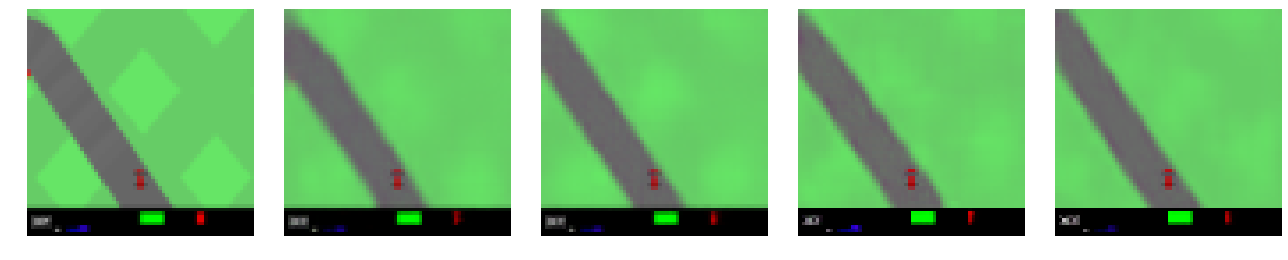

In [336]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


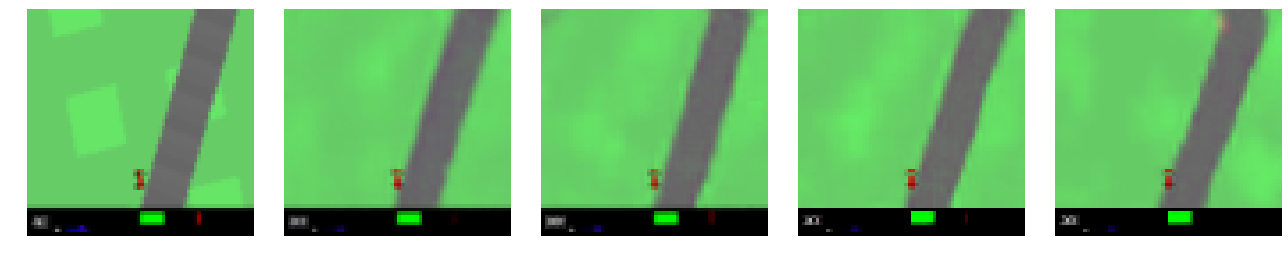

In [337]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


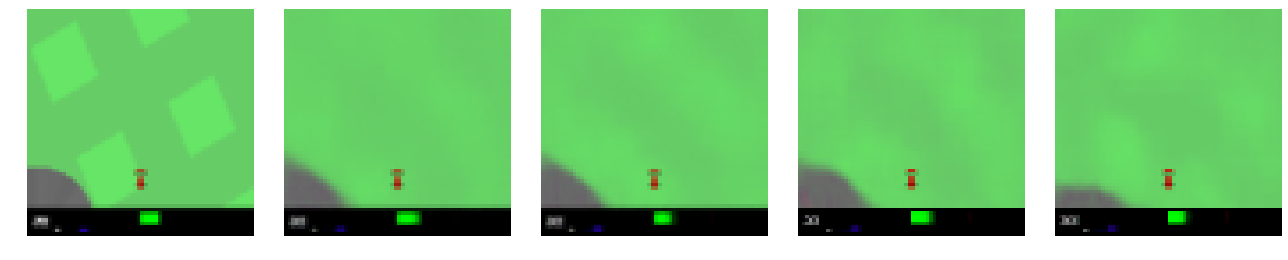

In [33]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


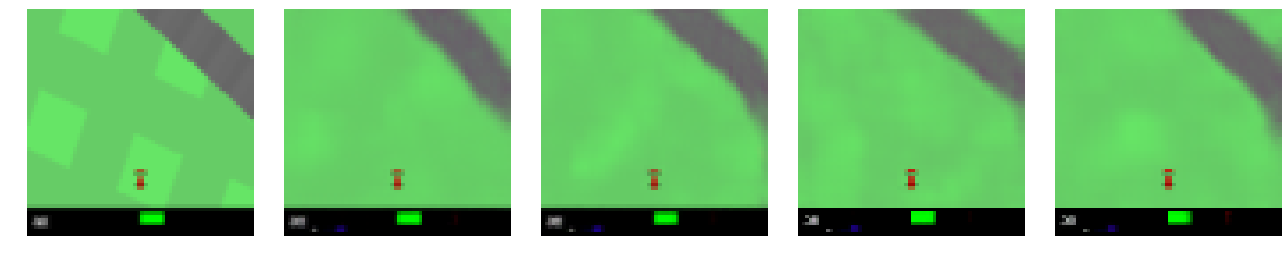

In [34]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


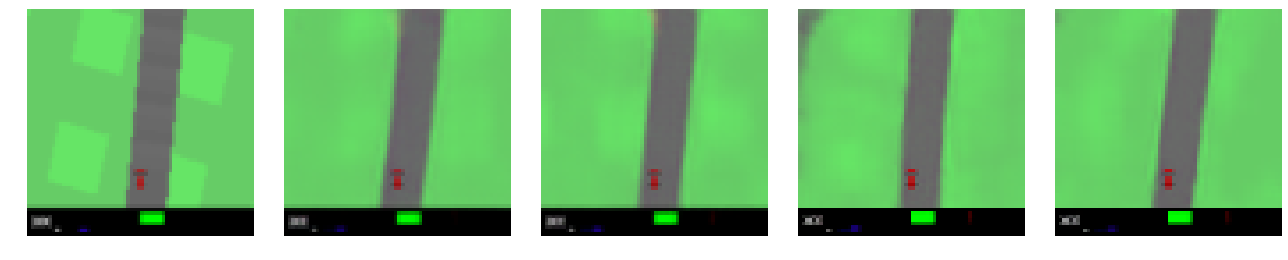

In [38]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


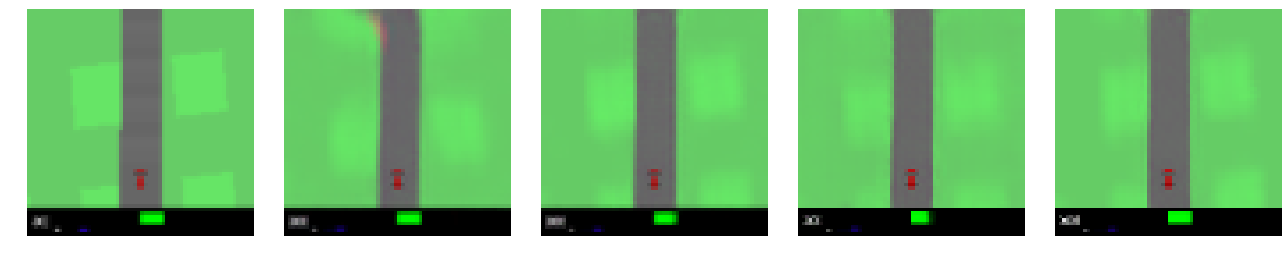

In [40]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


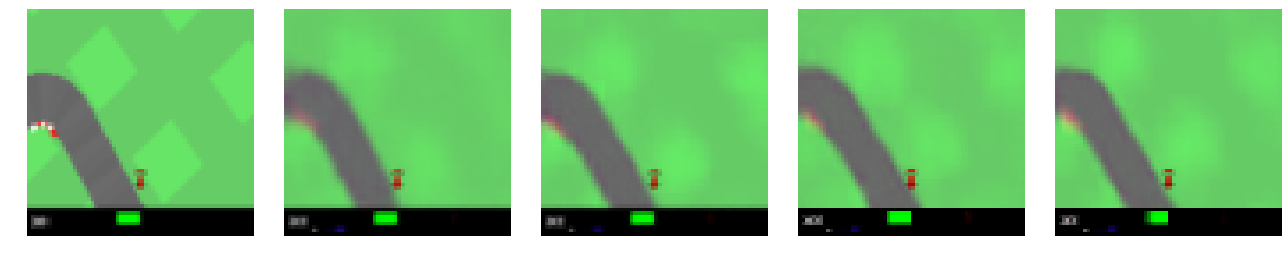

In [41]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


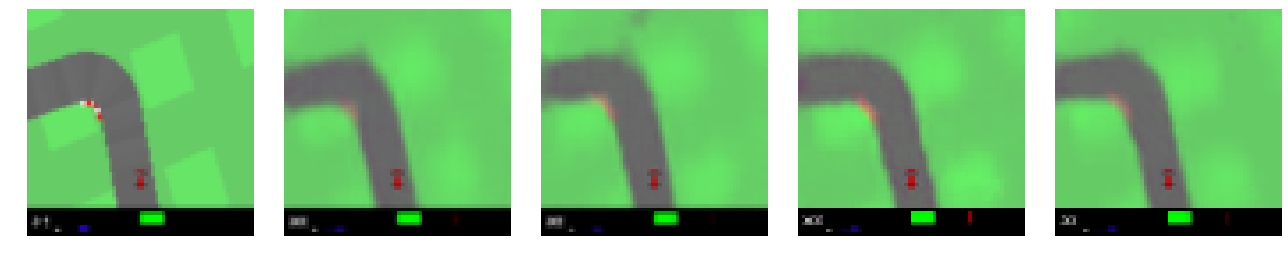

In [43]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


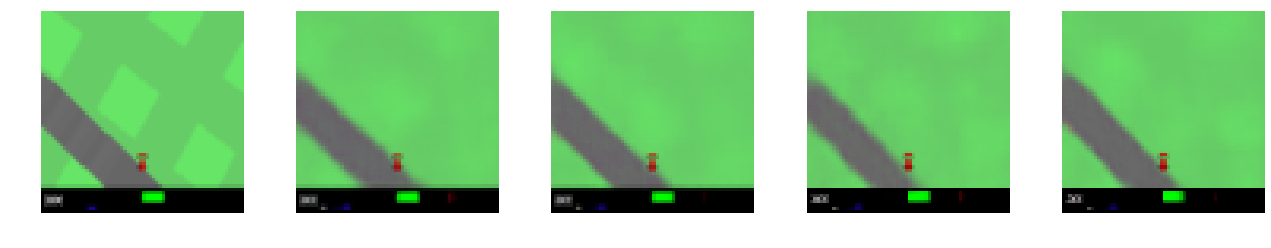

In [75]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


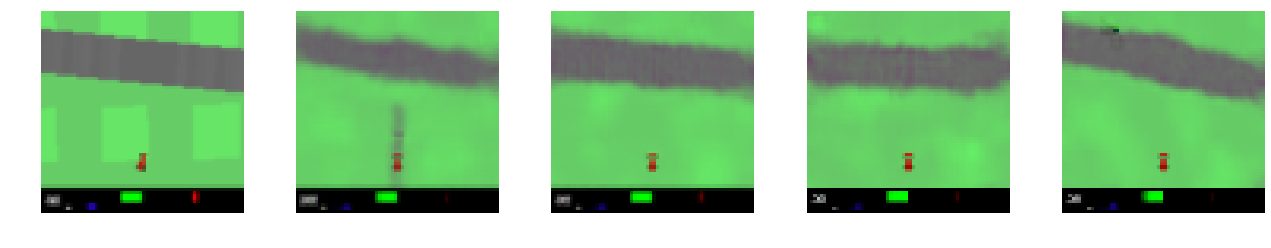

In [76]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


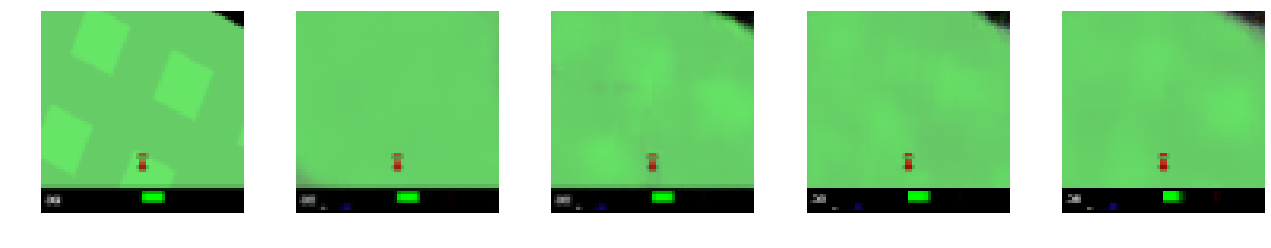

In [77]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

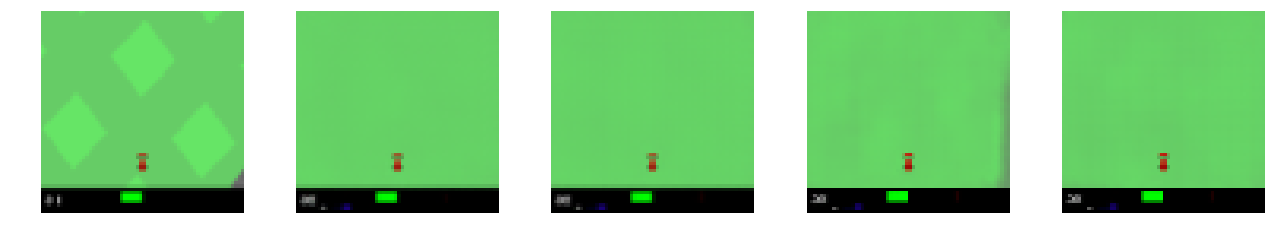

In [78]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

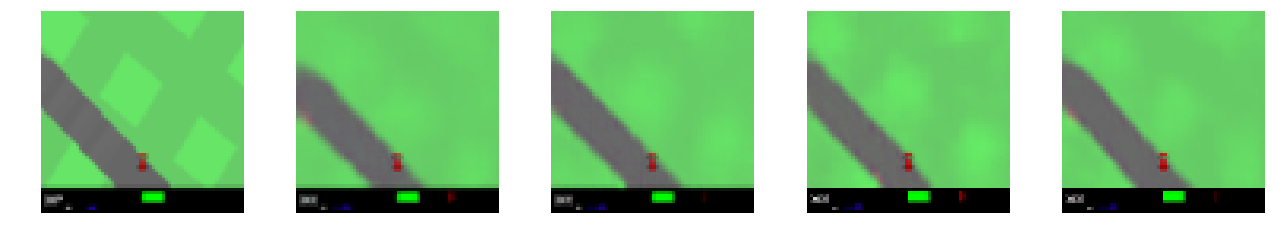

In [79]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

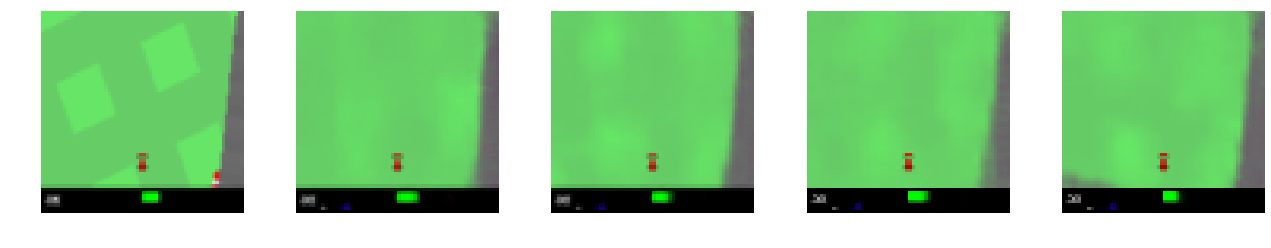

In [80]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

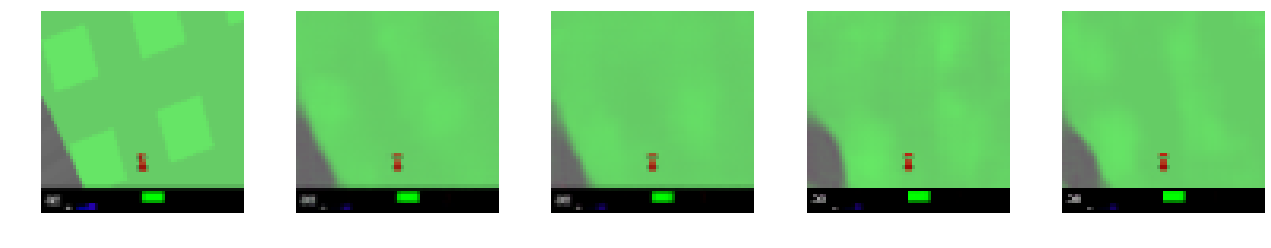

In [81]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

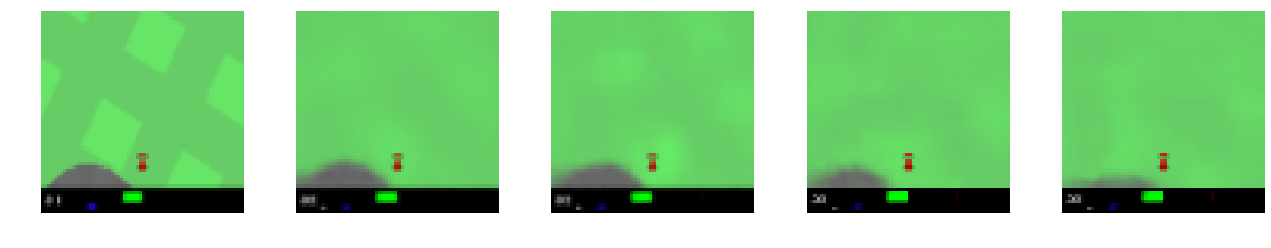

In [82]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

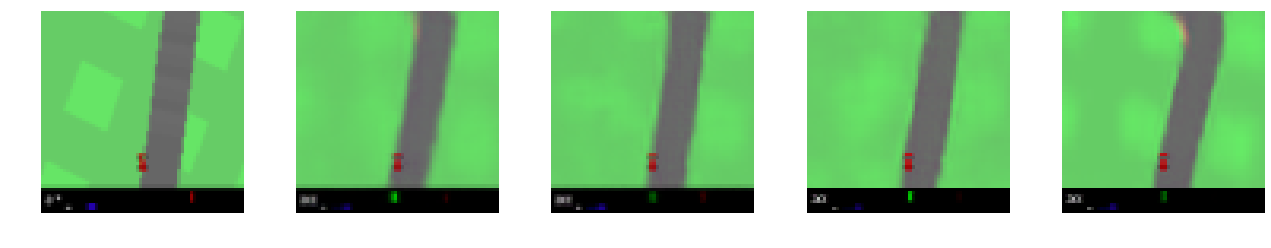

In [83]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

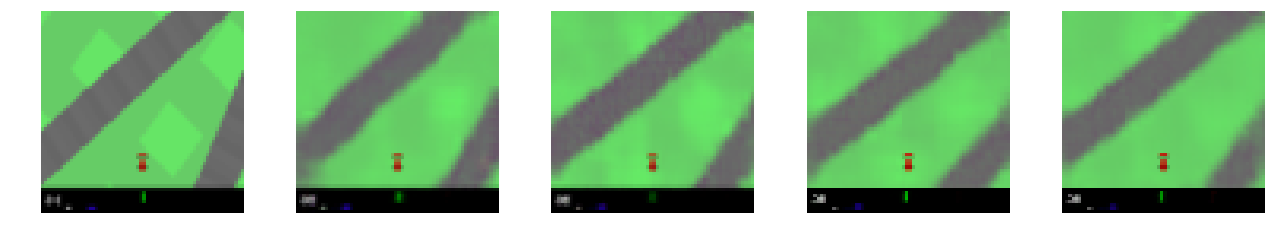

In [84]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

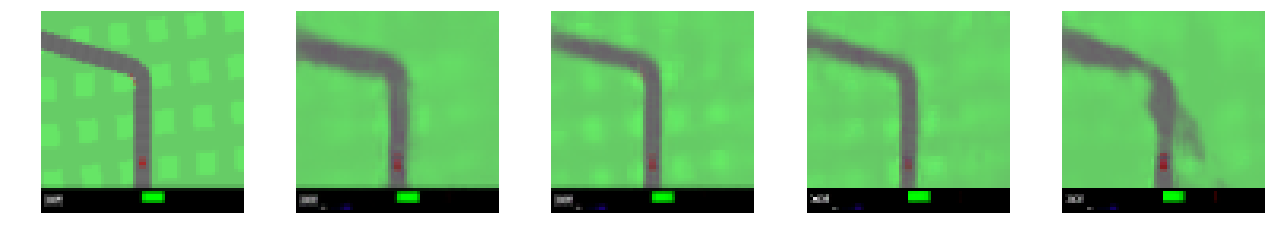

In [85]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

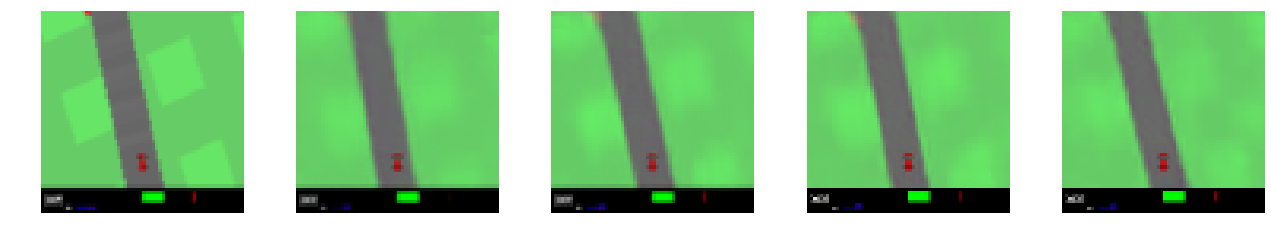

In [86]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

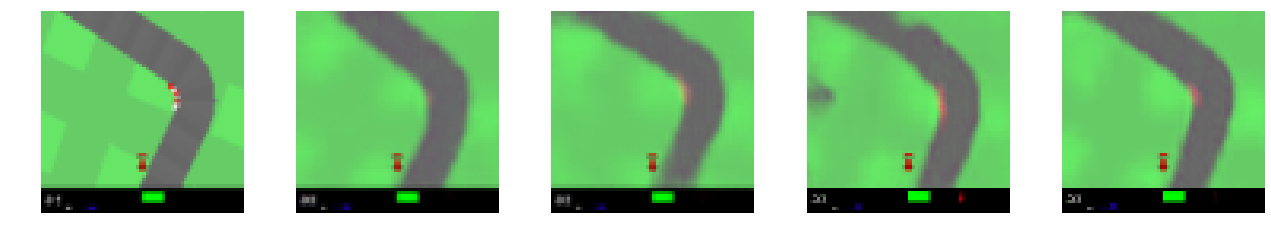

In [89]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

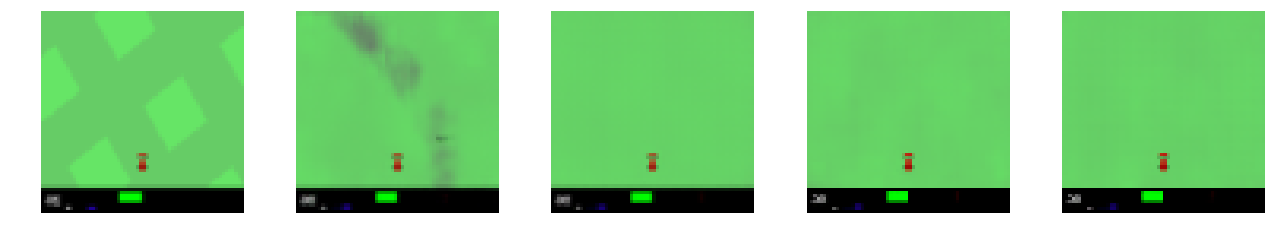

In [97]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

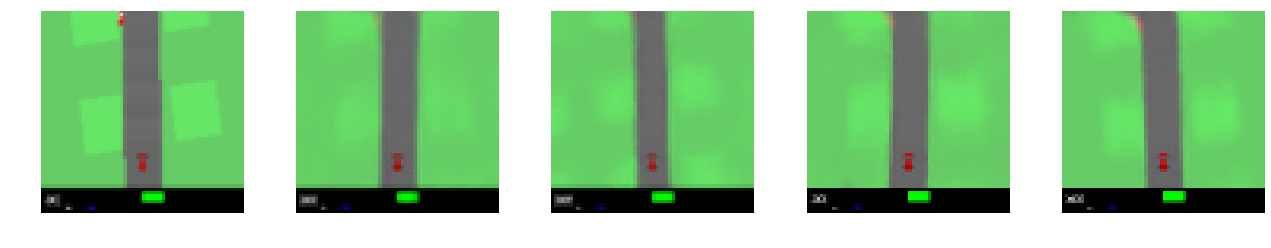

In [113]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

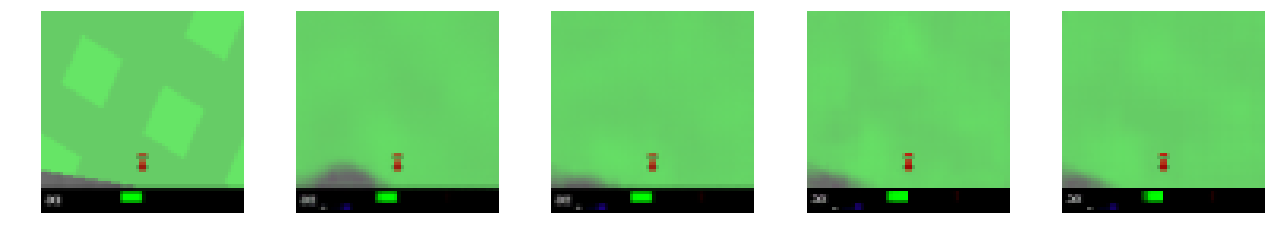

In [115]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

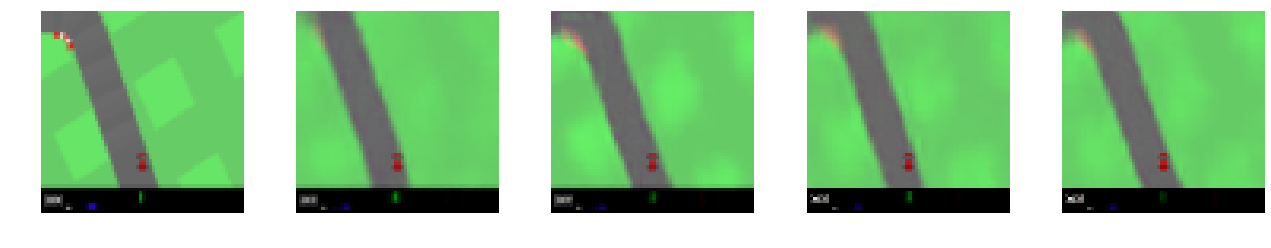

In [119]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

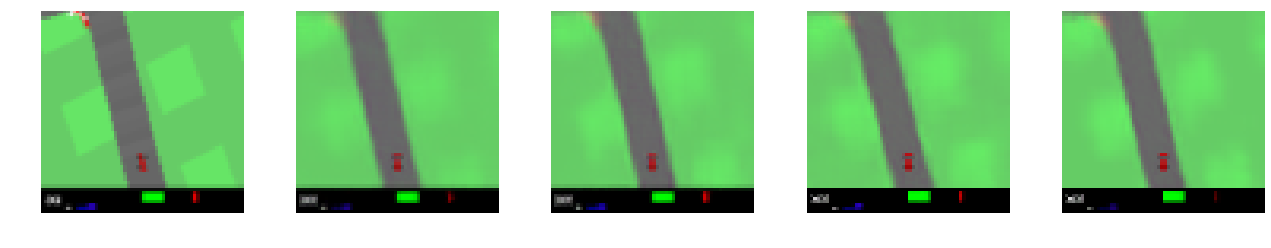

In [127]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

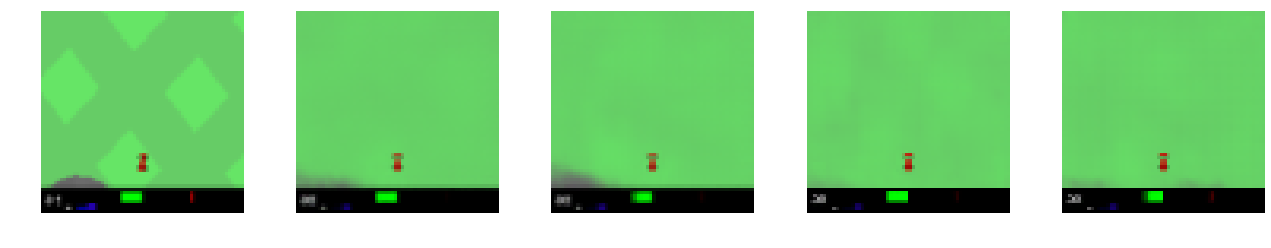

In [131]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

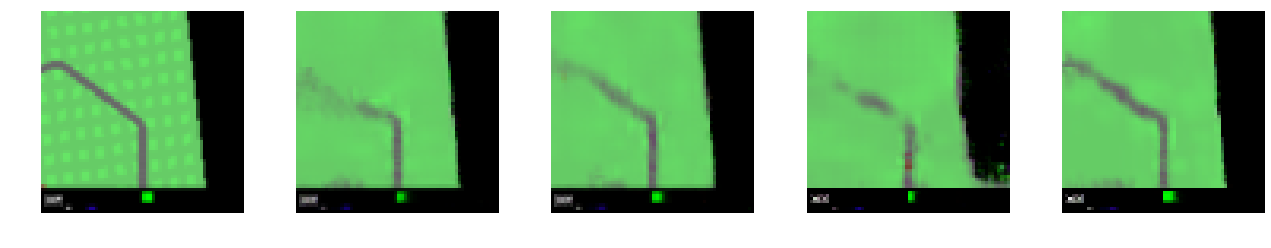

In [146]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

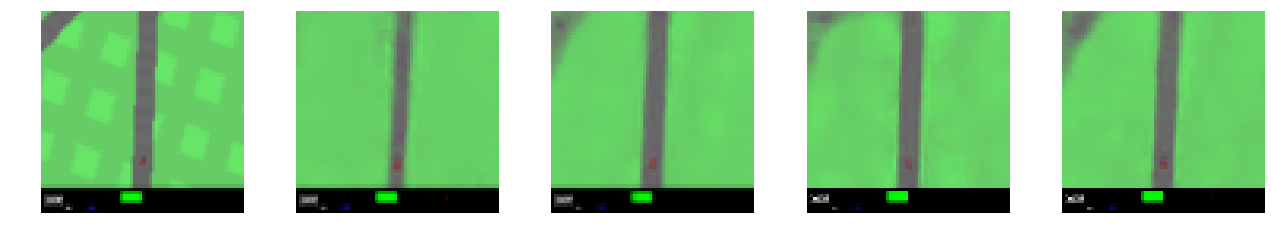

In [155]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

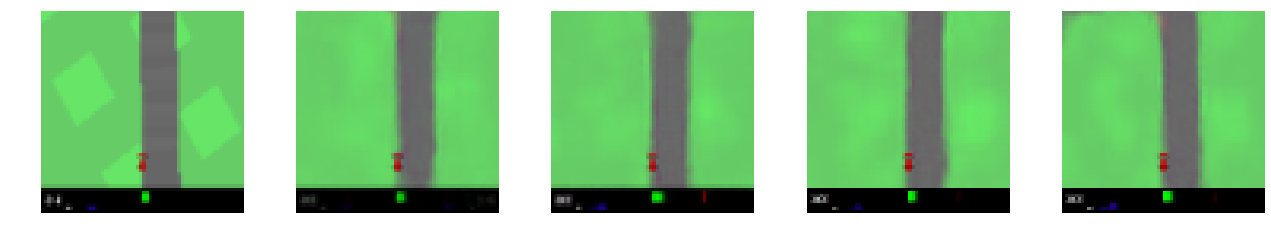

In [158]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

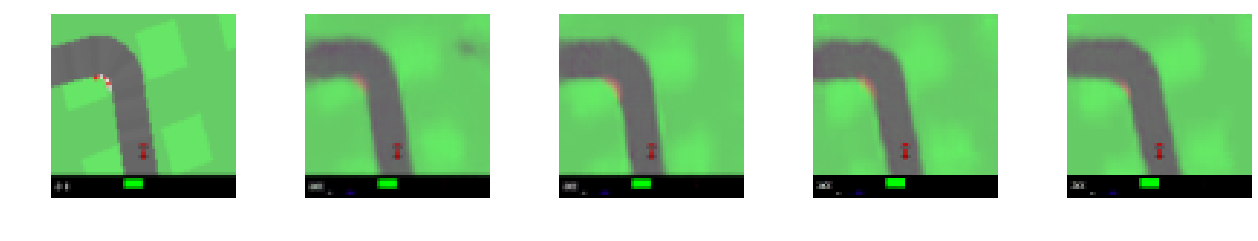

In [243]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

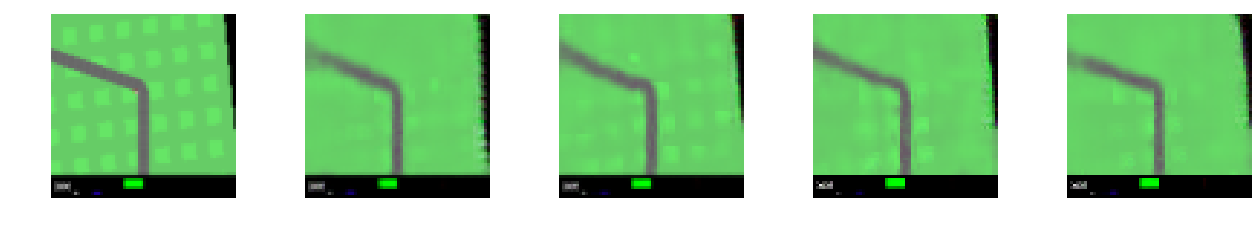

In [244]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

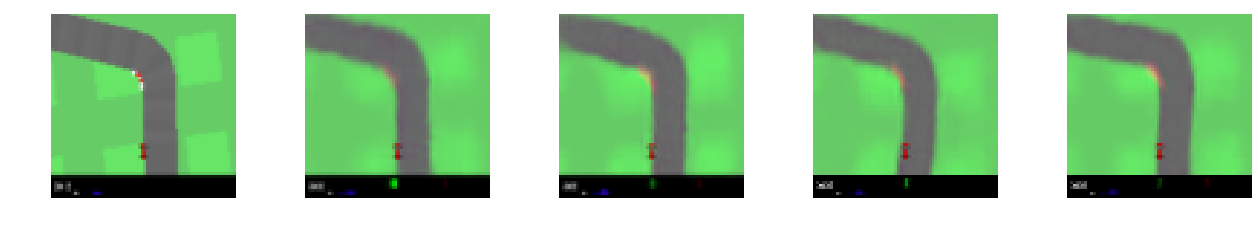

In [247]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

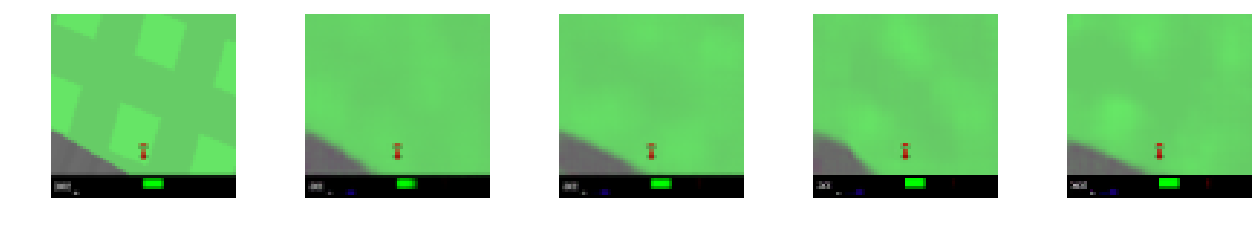

In [298]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

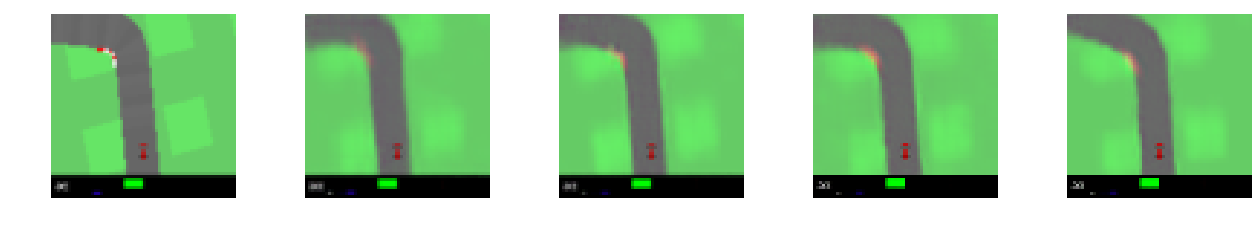

In [297]:
plt.tight_layout()
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen = compare_reconstructed_frame(vae_, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


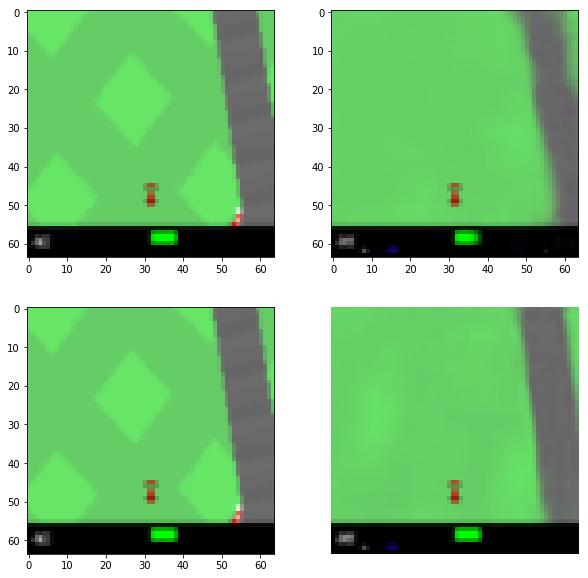

In [42]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


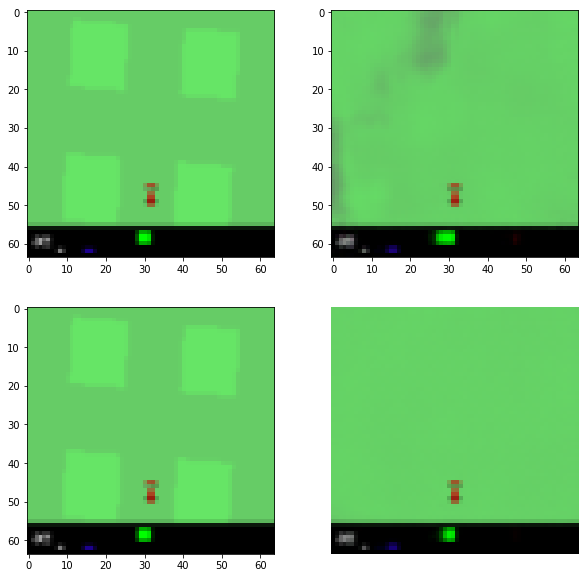

In [43]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


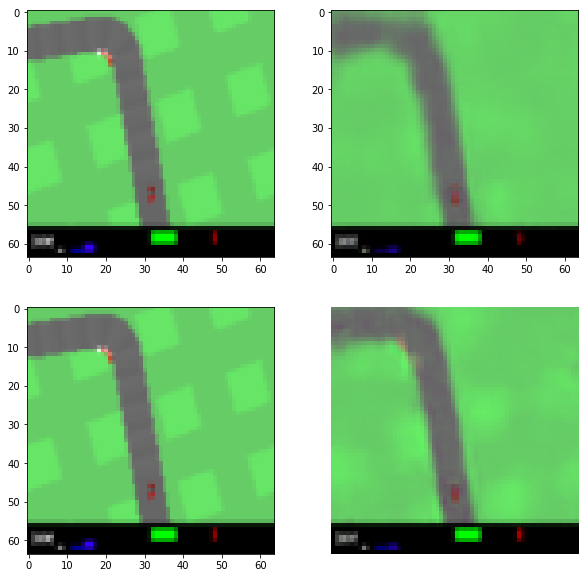

In [44]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


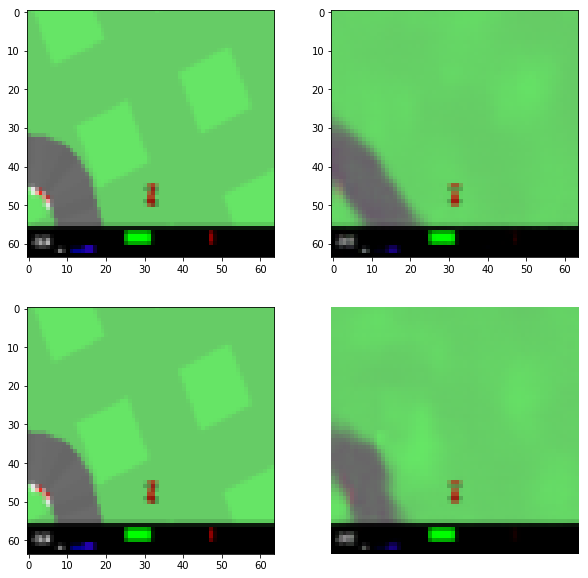

In [45]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


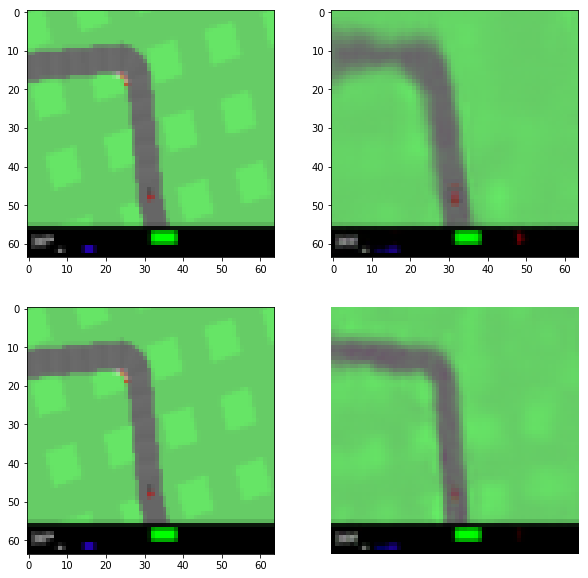

In [49]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


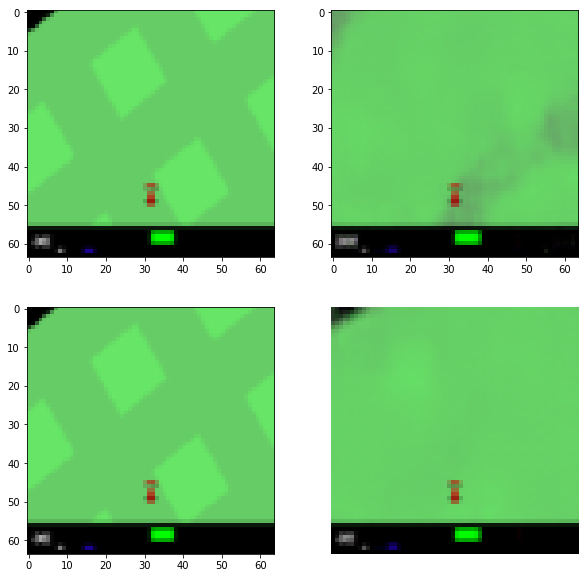

In [54]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


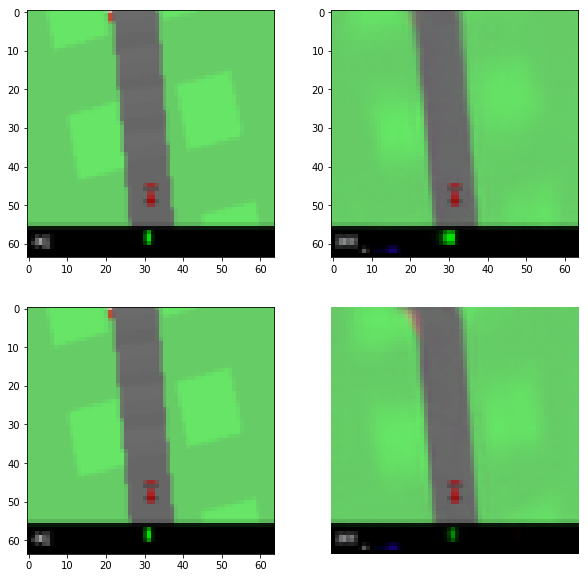

In [55]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


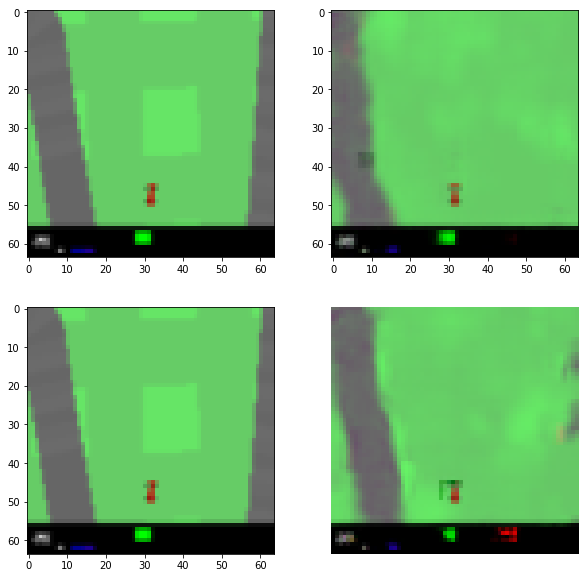

In [57]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


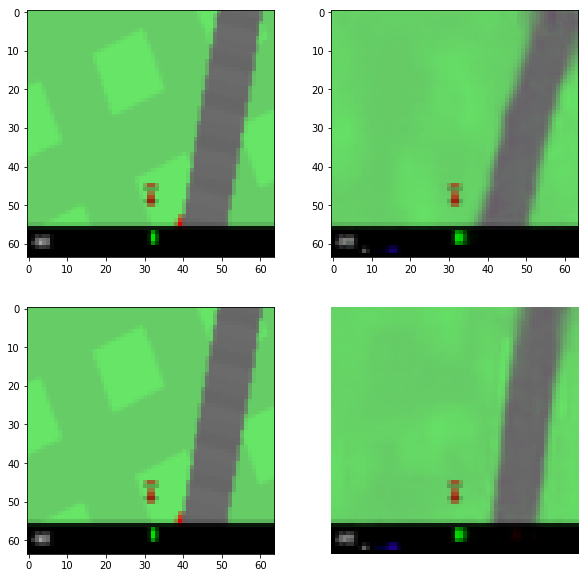

In [67]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


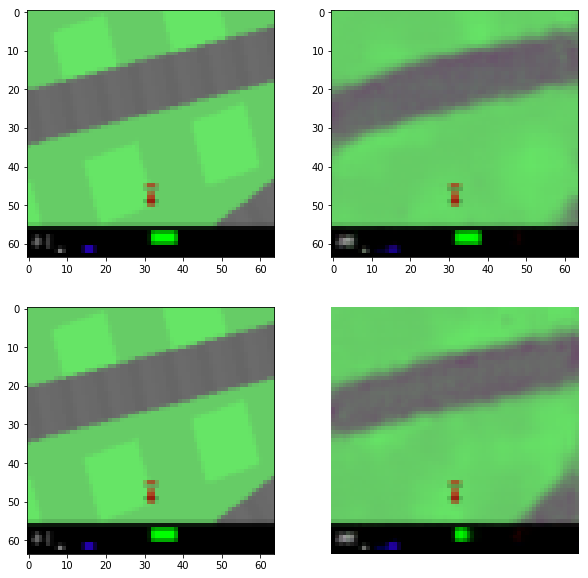

In [71]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


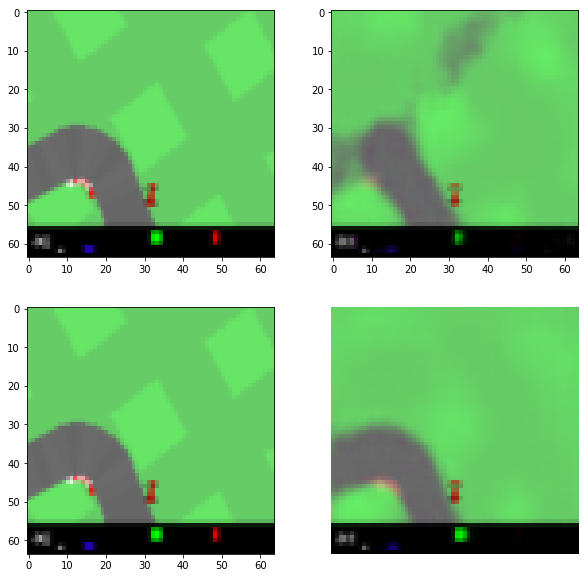

In [83]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

torch.Size([32, 3, 64, 64])


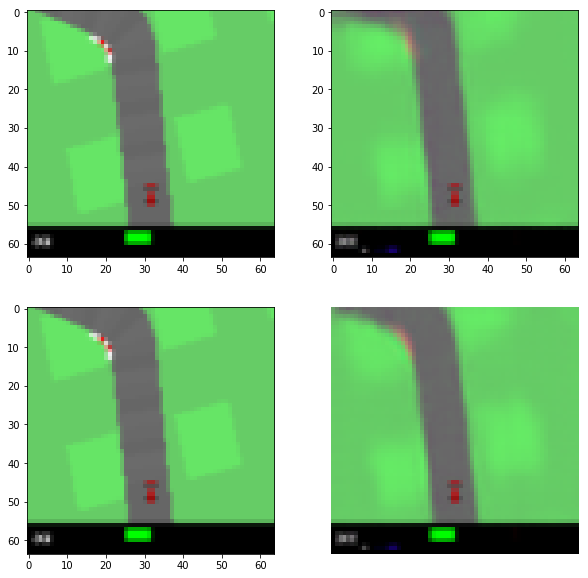

In [102]:
compare_reconstructed_frame(vae, vae_reward, test_loader_no_reward, 0)

In [45]:
reward_list_vaernn_vanilla_1 = pickle.load(open('train_controller_on_vae_vanilla_test.p','rb'))

In [46]:
reward_list_vaernn_vanilla_1

[-788.9706256217886]

In [ ]:
# final for vae with reward: 572.58 
# best for vae with reward: 788.56

# final for vae rnn gmm: 865.05
# best for vae rnn gmm: 912.93

# final for vae vanilla: 
# best for vae vanilla: 

# final for vae rnn obs: 
# best for vae rnn obs: 

In [29]:
reward_list_vaernn_gmm_pop64_1 = pickle.load(open('train_controller_on_vaernn_frozen.p','rb'))
reward_list_vaernn_gmm_pop64_2 = pickle.load(open('train_controller_on_vaernn_frozen_2_test.p','rb'))
reward_list_vaernn_gmm_pop64 = reward_list_vaernn_gmm_pop64_1 + reward_list_vaernn_gmm_pop64_2

788.561715989027

In [221]:
VAE_VANILLA_TRAIN = reward_list_vanilla_train
# scp into other and pickle 

In [299]:
# want each of reward_list_vae_rnn_obs_train to be in the dataset and plot so there's error band 
new_array = np.transpose(np.array(reward_list_vae_rnn_obs_train))

In [303]:
new_array = [inner for outer in new_array  for inner in outer]
len(new_array)

5120

In [307]:
new_array = [-r for r in new_array]

In [308]:
obs_train_df = pd.DataFrame()
obs_train_df['reward'] = new_array
obs_train_df['generation'] = list(range(80)) * 64 

In [311]:
obs_test_df = pd.DataFrame()
obs_test_df['reward'] = reward_list_vae_rnn_obs_test
obs_test_df['generation'] = [3 * x for x in list(range(26))]

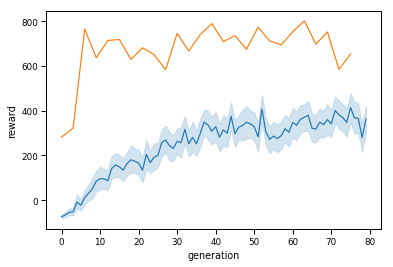

In [312]:
sns.set_context('paper')
f, ax = plt.subplots()
sns.lineplot(x='generation', y='reward', data=obs_train_df, estimator='mean', ax=ax)
sns.lineplot(x='generation', y='reward', data=obs_test_df, ax=ax)

In [230]:
reward_list_vae_rnn_obs_train = pickle.load(open('other/train_controller_on_vae_rnn_obs_train.p', 'rb')) # 'ctrl_vae_vanilla_pop64_NEW'
reward_list_vae_rnn_obs_test = pickle.load(open('other/train_controller_on_vae_rnn_obs_test.p', 'rb'))

In [201]:
reward_list_vanilla_train = pickle.load(open('train_controller_on_vae_vanilla_train.p', 'rb')) # 'ctrl_vae_vanilla_pop64_NEW'
reward_list_vanilla_test = pickle.load(open('train_controller_on_vae_vanilla_test.p', 'rb'))

In [18]:
reward_list_vaernn_gmm_pop64_1 = pickle.load(open('train_controller_on_vaernn_frozen.p','rb'))
reward_list_vaernn_gmm_pop64_2 = pickle.load(open('train_controller_on_vaernn_frozen_2_test.p','rb'))
reward_list_vaernn_gmm_pop64 = reward_list_vaernn_gmm_pop64_1 + reward_list_vaernn_gmm_pop64_2

In [197]:
# pop 64 reward lists 
VAERNN_GMM_TRAIN = reward_list_vaernn_gmm_pop64_1 # I NEED THE REST at 8pm 
VAERNN_GMM_TEST = reward_list_vaernn_gmm_pop64
VAE_VANILLA_TRAIN = reward_list_vanilla_train # WILL BE DONE at 3AM 
VAE_VANILLA_TEST = reward_list_vanilla_test # WILL BE DONE at 3AM 
# VAE_REWARD_TRAIN = # DECIDE WHETHER TO RUN THIS OR NOT AFTER MINE 
VAE_REWARD_TEST = reward_list_vae_reward_eval_pop64

In [233]:
VAERNN_OBS_TRAIN =  reward_list_vae_rnn_obs_train # GET PICKLE FROM SHARMAN at 2pm 
VAERNN_OBS_TEST = reward_list_vae_rnn_obs_test # GET PICKLE FROM SHARMAN at 2pm 

In [234]:
ULTIMATE_DF = pd.DataFrame()
# ULTIMATE_DF['VAERNN_GMM_TRAIN'] = VAERNN_GMM_TRAIN 
ULTIMATE_DF['VAERNN_GMM_TEST'] = VAERNN_GMM_TEST + [0] * 53
ULTIMATE_DF['VAERNN_OBS_TRAIN'] = VAERNN_OBS_TRAIN 
ULTIMATE_DF['VAERNN_OBS_TEST'] = VAERNN_OBS_TEST + [0] * 54
ULTIMATE_DF['VAE_VANILLA_TRAIN'] = VAE_VANILLA_TRAIN
ULTIMATE_DF['VAE_VANILLA_TEST'] = VAE_VANILLA_TEST + [0] * 54
# ULTIMATE_DF['VAE_REWARD_TRAIN'] = VAE_REWARD_TRAIN 
ULTIMATE_DF['VAE_REWARD_TEST'] = VAE_REWARD_TEST + [0] * 53

In [223]:
ULTIMATE_DF.to_csv('ultimate_df.csv')

In [19]:
reward_list_vanilla = pickle.load(open('train_controller_on_vanilla.p','rb'))

In [20]:
reward_list_vae_reward_eval = pickle.load(open('train_controller_on_vae_reward_eval.p','rb'))

In [21]:
reward_list_vaernn = pickle.load(open('train_controller_on_vaernn.p','rb'))

In [22]:
reward_list_vae_reward_eval_pop64 = pickle.load(open('train_controller_on_vae_reward_eval_pop64.p','rb'))

In [209]:
reward_list_vanilla = [-r for r in reward_list_vanilla]
reward_list_vae_reward_eval = [-r for r in reward_list_vae_reward_eval]
reward_list_vaernn = [-r for r in reward_list_vaernn]
reward_list_vae_reward_eval_pop64 = [-r for r in reward_list_vae_reward_eval_pop64] 

In [24]:
reward_list_vaernn_gmm_pop64 = [-r for r in reward_list_vaernn_gmm_pop64]

In [213]:
reward_list_vanilla_test = [-r for r in reward_list_vanilla_test] 
# reward_list_vanilla_train = [-r for r in reward_list_vanilla_train] 

In [238]:
reward_list_vae_rnn_obs_test = [-r for r in reward_list_vae_rnn_obs_test]

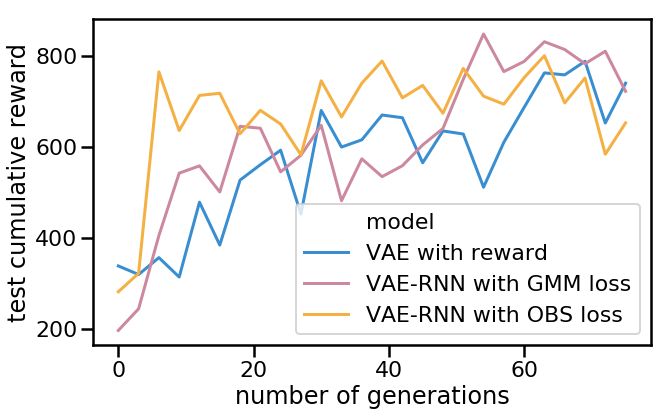

In [314]:
test_reward_df = pd.DataFrame()
test_reward_df['test cumulative reward'] = reward_list_vae_reward_eval_pop64[:-1] + reward_list_vaernn_gmm_pop64[:-1] + reward_list_vae_rnn_obs_test # + reward_list_vanilla_test 
test_reward_df['number of generations'] = [l * 3 for l in list(range(26))] * 3 # 4 
test_reward_df['model'] = ['VAE with reward'] * 26 + ['VAE-RNN with GMM loss'] * 26 + ['VAE-RNN with OBS loss'] * 26 # +  ['VAE vanilla'] * 26 
plt.figure(figsize=(10,6))
flatui = ["#388ed1", "#cc889f", "#f4b042"]#, '#2fcc04']
palette=sns.color_palette(flatui)
sns.set_context('poster')
sns.lineplot(x='number of generations', y='test cumulative reward', hue='model', data=test_reward_df, palette=palette)
# plt.plot(reward_list_vanilla, label='vanilla')
# plt.plot(reward_list_vae_reward_eval, label=' vae with reward')
# plt.plot(reward_list_vaernn, label='vaernn')
# plt.plot(reward_list_vae_reward_eval_pop64, label='vae with reward pop 64')
# plt.plot(reward_list_vaernn_gmm_pop64, label='vae rnn with gmm pop 64')
# plt.legend()
# plt.show()

In [204]:
len(reward_list_vae_reward_eval_pop64[:-1])

26

In [177]:
df = pd.DataFrame()
df['iter'] = list(range(len(reward_list_vanilla))) * 3 
df['reward'] = reward_list_vanilla + reward_list_vae_reward_eval + reward_list_vaernn 
df['model'] = ['vanilla'] * len(reward_list_vanilla) + ['vae_reward_eval'] * len(reward_list_vae_reward_eval) + ['vaernn'] * len(reward_list_vaernn )

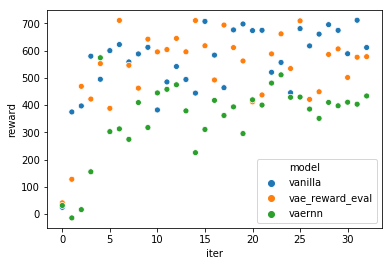

In [179]:
sns.scatterplot(x = 'iter', y='reward', data=df, hue='model')

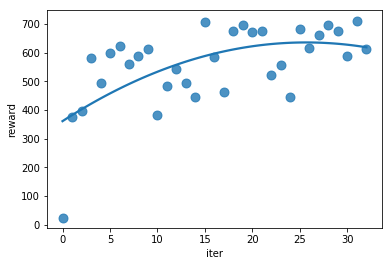

In [183]:
sns.regplot(x = 'iter', y='reward', data=df[df['model'] =='vanilla'], scatter_kws={"s": 80},
...                  order=2, ci=None, truncate=True)

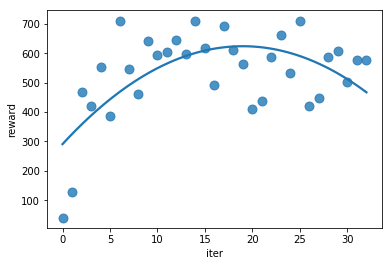

In [184]:
sns.regplot(x = 'iter', y='reward', data=df[df['model'] =='vae_reward_eval'], scatter_kws={"s": 80},
...                  order=2, ci=None, truncate=True)

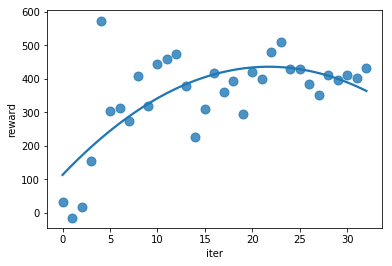

In [185]:
sns.regplot(x = 'iter', y='reward', data=df[df['model'] =='vaernn'], scatter_kws={"s": 80},
...                  order=2, ci=None, truncate=True)

In [188]:
vaernnnotawesome = pickle.load(open('/home/gengar888/enhanced_world_models/vae_rnn_no_gmm.p', 'rb'))

In [193]:
train_loss_vaernn_obs = vaernnnotawesome['train']['av_loss']
train_mse_vaernn_obs = vaernnnotawesome['train']['av_mse_loss']
test_loss_vaernn_obs = vaernnnotawesome['test']['av_loss']
test_mse_vaernn_obs = vaernnnotawesome['test']['av_mse_loss']

In [162]:
vaernnawesome = pickle.load(open('/home/gengar888/enhanced_world_models/vaernnawesome.p','rb'))

In [166]:
train_loss_vaernn_gmm = vaernnawesome['train']['loss']
train_mse_vaernn_gmm = vaernnawesome['train']['mse']
test_loss_vaernn_gmm = vaernnawesome['test']['loss']
test_mse_vaernn_gmm = vaernnawesome['test']['mse']

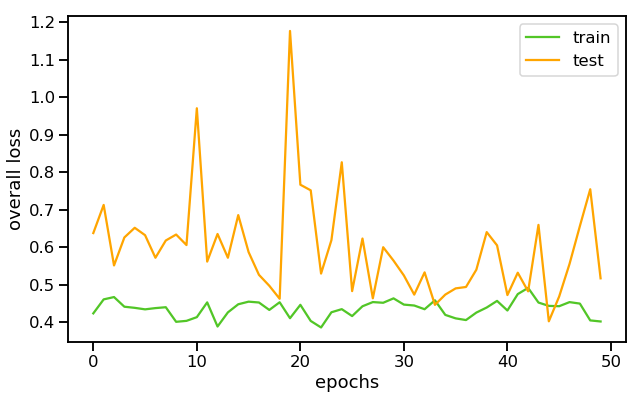

In [176]:
vaernn_df = pd.DataFrame()
vaernn_df['overall loss'] = train_loss_vaernn_gmm + test_loss_vaernn_gmm
vaernn_df[''] = ['train'] * len(train_loss_vaernn_gmm) + ['test'] * len(test_loss_vaernn_gmm)
vaernn_df['epochs'] = list(range(len(train_loss_vaernn_gmm))) * 2 

# test_reward_df['number of generations'] = [l * 3 for l in list(range(27))] * 2 
# test_reward_df['model'] = ['VAE with reward'] * 27 + ['VAE-RNN with GMM loss'] * 27 
plt.figure(figsize=(10,6))
flatui = ["#52c627", "#ffa500"]
palette=sns.color_palette(flatui)
sns.set_context('talk')
sns.lineplot(x='epochs', y='overall loss', hue='', data=vaernn_df, palette=palette)
# plt.plot(reward_list_vanilla, label='vanilla')
# plt.plot(reward_list_vae_reward_eval, label=' vae with reward')
# plt.plot(reward_list_vaernn, label='vaernn')
# plt.plot(reward_list_vae_reward_eval_pop64, label='vae with reward pop 64')
# plt.plot(reward_list_vaernn_gmm_pop64, label='vae rnn with gmm pop 64')
# plt.legend()
# plt.show()